# set environment

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from feature_engineering import refuting_features, polarity_features, hand_features
from feature_engineering import word_overlap_features


Using TensorFlow backend.


# preprocessing

## import dataset 

In [2]:
FOLDER_PATH = '/Users/hongtingyin/desktop/projects/Stance_Detection_B/dataset/'
BODYDATA_FILE_PATH = FOLDER_PATH + 'bodies.csv'
TRAINDATA_FILE_PATH = FOLDER_PATH + 'stances.csv' 
body_df = pd.read_csv(BODYDATA_FILE_PATH, usecols=['Body ID', 'articleBody'])
stance_df = pd.read_csv(TRAINDATA_FILE_PATH, usecols=['Headline', 'Body ID', 'Stance'])

In [3]:
body_df.shape

(1683, 2)

In [4]:
body_df.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [5]:
stance_df.shape

(49972, 3)

In [6]:
stance_df.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [7]:
stance_df.columns[2]
stance_df.groupby(stance_df.columns[2]).count()

,Headline,Body ID
Stance,,
agree,3678,3678
disagree,840,840
discuss,8909,8909
unrelated,36545,36545


In [8]:
agree, disagree, discuss, unrelated = stance_df.groupby(stance_df.columns[2])

In [9]:
agree_df = pd.DataFrame((list(agree))[1])
disagree_df = pd.DataFrame((list(disagree))[1])
discuss_df = pd.DataFrame((list(discuss))[1])
unrelated_df = pd.DataFrame((list(unrelated))[1])

In [10]:
print(agree_df.shape)
print(disagree_df.shape)
print(discuss_df.shape)
print(unrelated_df.shape)

(3678, 3)
(840, 3)
(8909, 3)
(36545, 3)


distribution of dataset:
7%   agree
2%   disagree
18%  discuss
73%  unrelated

In [13]:
from sklearn import model_selection

train_agree, test_agree = model_selection.train_test_split(agree_df, test_size=0.1, random_state=42)
train_agree, valid_agree = model_selection.train_test_split(train_agree, test_size=0.2, random_state=42)
# print(train_agree.shape)
# print(test_agree.shape)
# print(valid_agree.shape)

train_disagree, test_disagree = model_selection.train_test_split(disagree_df, test_size=0.1, random_state=42)
train_disagree, valid_disagree = model_selection.train_test_split(train_disagree, test_size=0.2, random_state=42)
# print(train_disagree.shape)
# print(test_disagree.shape)
# print(valid_disagree.shape)

train_discuss, test_discuss = model_selection.train_test_split(discuss_df, test_size=0.1, random_state=42)
train_discuss, valid_discuss = model_selection.train_test_split(train_discuss, test_size=0.2, random_state=42)
# print(train_discuss.shape)
# print(test_discuss.shape)
# print(valid_discuss.shape)

train_unrelated, test_unrelated = model_selection.train_test_split(unrelated_df, test_size=0.1, random_state=42)
train_unrelated, valid_unrelated = model_selection.train_test_split(train_unrelated, test_size=0.2, random_state=42)
# print(train_unrelated.shape)
# print(test_unrelated.shape)
# print(valid_unrelated.shape)

In [14]:
train = train_agree.append([train_disagree, train_discuss, train_unrelated])
test = test_agree.append([test_disagree, test_discuss, test_unrelated])
valid = valid_agree.append([valid_disagree, valid_discuss, valid_unrelated])

from sklearn.utils import shuffle
train = shuffle(train)
test = shuffle(test)
valid = shuffle(valid)

print(train.shape)
print(test.shape)
print(valid.shape)

(35978, 3)
(4998, 3)
(8996, 3)


In [15]:
test.columns[2]
test.groupby(stance_df.columns[2]).count()

,Headline,Body ID
Stance,,
agree,368,368
disagree,84,84
discuss,891,891
unrelated,3655,3655


72% training; 10% testing; 18% validation

In [16]:
# train.to_csv('train.csv')
# test.to_csv('test.csv')
# valid.to_csv('valid.csv')

In [16]:
full_train = pd.merge(train, body_df, on='Body ID')
full_test = pd.merge(test, body_df, on='Body ID')
full_valid = pd.merge(valid, body_df, on = 'Body ID')

# print(full_train.shape)
# print(full_test.shape)
# print(full_valid.shape)

In [17]:
full_data = full_train.append([full_valid, full_test])
print(full_data.shape)

(49972, 4)


In [18]:
full_data['stanceLevel'] = full_data['Stance'].map({'agree':0, 'disagree':1, 'discuss':2, 'unrelated':3})

In [19]:
full_data.shape

(49972, 5)

In [21]:
# full_data.to_csv('full_data.csv')

In [20]:
full_data.head()

,Headline,Body ID,Stance,articleBody,stanceLevel
0,ISIS Border Crisis: DHS Chief Says Terrorists ...,1022,unrelated,A man had his genitals chopped off and thrown ...,3
1,Report: NYPD to stop arresting people for mino...,1022,unrelated,A man had his genitals chopped off and thrown ...,3
2,Macklemore Gets Twitter-Trolled with the #Mack...,1022,unrelated,A man had his genitals chopped off and thrown ...,3
3,"Jihadi John named as Mohammed Emwazi, from wes...",1022,unrelated,A man had his genitals chopped off and thrown ...,3
4,NYPD to issue tickets instead of arrest for we...,1022,unrelated,A man had his genitals chopped off and thrown ...,3


In [21]:
word_seq = [text_to_word_sequence(sent) for sent in full_data['articleBody']]
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq], 90))

90th Percentile Sentence Length: 683.0


In [22]:
word_seq = [text_to_word_sequence(sent) for sent in full_data['Headline']]
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq], 90))

90th Percentile Sentence Length: 16.0


In [23]:
full_data['articleBody'] = full_data['articleBody'].str.lower()
full_data['Headline'] = full_data['Headline'].str.lower()

full_data['articleBody'] = full_data['articleBody'].apply((lambda x: re.sub('[^a-zA-z0-9\\s]',' ',x)))
full_data['Headline'] = full_data['Headline'].apply((lambda x: re.sub('[^a-zA-z0-9\\s]',' ',x)))

full_data["articleBody"] = full_data['articleBody'].str.replace('[^\w\s]',' ')
full_data["Headline"] = full_data['Headline'].str.replace('[^\w\s]',' ')

In [24]:
full_data.head()

,Headline,Body ID,Stance,articleBody,stanceLevel
0,isis border crisis dhs chief says terrorists ...,1022,unrelated,a man had his genitals chopped off and thrown ...,3
1,report nypd to stop arresting people for mino...,1022,unrelated,a man had his genitals chopped off and thrown ...,3
2,macklemore gets twitter trolled with the mack...,1022,unrelated,a man had his genitals chopped off and thrown ...,3
3,jihadi john named as mohammed emwazi from wes...,1022,unrelated,a man had his genitals chopped off and thrown ...,3
4,nypd to issue tickets instead of arrest for we...,1022,unrelated,a man had his genitals chopped off and thrown ...,3


In [25]:
%%time
question_list = list(full_data['Headline'])
question_list = [' '.join(word_tokenize(q)[:16]) for q in question_list]

CPU times: user 4.67 s, sys: 27.9 ms, total: 4.7 s
Wall time: 4.75 s


In [28]:
print(len(question_list))

49972


In [29]:
# question_list_df = pd.DataFrame(question_list)
# question_list_df.to_csv('question_list_df.csv')

In [26]:
%%time
body_list = list(full_data["articleBody"])
body_list = [' '.join(word_tokenize(q)[:683]) for q in body_list]

CPU times: user 57.9 s, sys: 195 ms, total: 58.1 s
Wall time: 58.3 s


In [31]:
# print(len(body_list))

In [32]:
# body_list_df = pd.DataFrame(body_list)
# body_list_df.to_csv('body_list_df.csv')

# extra features 

There are 4 functions imported from "feature_engineering" using for extracting extra features.

In [27]:
word_overlap_feature = word_overlap_features(question_list, body_list)
refuting_feature = refuting_features(question_list, body_list)
polarity_feature = polarity_features(question_list, body_list)
hand_feature = hand_features(question_list, body_list)

49972it [02:12, 378.10it/s]
49972it [00:08, 5980.22it/s]
49972it [02:12, 377.94it/s]
49972it [02:55, 284.23it/s]


In [34]:
# print(type(word_overlap_feature))
# print(type(refuting_feature))
# print(type(polarity_feature))
# print(type(hand_feature))

In [35]:
# print(len(word_overlap_feature[0]))
# print(len(refuting_feature[0]))
# print(len(polarity_feature[0]))
# print(len(hand_feature[0]))

In [28]:
extra_feature = np.c_[word_overlap_feature, refuting_feature, polarity_feature, hand_feature]
# print(type(extra_feature))
# print(extra_feature.shape)

In [29]:
# Concatenate features for train
train_extra_feature = extra_feature[:len(full_train)]
# Concatenate features for valid
valid_extra_feature = extra_feature[len(full_train):len(full_train) + len(full_valid)]
# Concatenate features for test
test_extra_feature = extra_feature[len(full_train) + len(full_valid):]

In [30]:
print(train_extra_feature.shape)
print(valid_extra_feature.shape)
print(test_extra_feature.shape)

(35978, 44)
(8996, 44)
(4998, 44)


In [31]:
whole_list = question_list + body_list

In [40]:
# print(len(whole_list))

In [32]:
# Filters - removed '?' 
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n') 
tokenizer.fit_on_texts(whole_list)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 22064


In [42]:
# whole_list_df = pd.DataFrame(whole_list)
# whole_list_df.to_csv('whole_list_df.csv')

## create dictionary 

In [33]:
MAX_VOCAB_SIZE = 30000
word_index = {k: v for k, v in tokenizer.word_index.items() if v < MAX_VOCAB_SIZE}
idx_to_word = dict((v, k) for k,v in word_index.items())

In [34]:
X = tokenizer.texts_to_sequences(whole_list)
X = pad_sequences(X, padding='post', truncating='post')

In [35]:
# print(len(X))

In [36]:
X_headline = X[:len(X)//2]
X_article = X[len(X)//2:]

In [47]:
# print(len(X_headline))
# print(len(X_article))

In [48]:
# print(type(X_headline))

# split data

In [37]:
X_train_headline = X_headline[:len(full_train)]
X_valid_headline = X_headline[len(full_train):len(full_train) + len(full_valid)]
X_test_headline = X_headline[len(full_train) + len(full_valid):]

print(X_train_headline.shape)
print(X_valid_headline.shape)
print(X_test_headline.shape)

(35978, 691)
(8996, 691)
(4998, 691)


In [38]:
X_train_article = X_article[:len(full_train)]
X_valid_article = X_article[len(full_train):len(full_train) + len(full_valid)]
X_test_article = X_article[len(full_train) + len(full_valid):]

print(X_train_article.shape)
print(X_valid_article.shape)
print(X_test_article.shape)

(35978, 691)
(8996, 691)
(4998, 691)


In [39]:
Y = full_data['stanceLevel'].values

Y_train = Y[:len(full_train)]
Y_valid = Y[len(full_train):len(full_train) + len(full_valid)]
Y_test = Y[len(full_train) + len(full_valid):]

print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(35978,)
(8996,)
(4998,)


In [52]:
# Y_train_df = pd.DataFrame(Y_train)
# Y_train_df.to_csv('Y_train_df.csv')

# Y_valid_df = pd.DataFrame(Y_valid)
# Y_valid_df.to_csv('Y_valid_df.csv')

# Y_test_df = pd.DataFrame(Y_test)
# Y_test_df.to_csv('Y_test_df.csv')

# Embedding Matrix

In [40]:
# Load GloVe word embeddings 
# Download Link: https://nlp.stanford.edu/projects/glove/
print("[INFO]: Reading Word Embeddings ...")
# Data path
embeddings = {}
EMB_DIR = FOLDER_PATH + 'glove.6B.300d.txt'
f = open(EMB_DIR)
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
EMBEDDING_DIM = 300
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

[INFO]: Reading Word Embeddings ...


# CNN_model1_20epoch

3 inputs (headline, article, extra_feature)

In [41]:
from keras.models import Model
from keras.layers import Layer, Input, Dense, Concatenate, Conv1D, Reshape, MaxPooling1D, Flatten, BatchNormalization, Activation, Dropout, Embedding, GlobalMaxPooling1D, Multiply
import keras.backend as K
from keras.utils import plot_model 
from IPython.display import Image

num_filters = 32 
filter_length = 4
dense_neuron = 16
MAX_SENT_LEN = 691
BATCH_SIZE = 32
N_EPOCHS = 20

class Abs(Layer):
    def __init__(self, **kwargs):
        super(Abs, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.abs(x[0]- x[1])

    def get_output_shape_for(self, input_shape):
        return input_shape
    
input_1 = Input(shape=(MAX_SENT_LEN, ), dtype='int32', name='Headline_input')
otherInp = Input(shape = (44, ), name='extra_features')
emb_look_up = Embedding(input_dim=22065,
                        output_dim=EMBEDDING_DIM,
                        weights = [embeddings_matrix], 
                        trainable=False, 
                        mask_zero=False,
                        name='Headline_articleBody_embedding_lookup')

emb_1 = emb_look_up(input_1)
conv_1 = Conv1D(activation="relu", filters=32, kernel_size=4, strides=1, padding="valid")(emb_1)
dense_1 = Dropout(0.2, name='dense_conv_1_dropout')(conv_1)
max_pool_1 = GlobalMaxPooling1D()(dense_1)

input_2 = Input(shape=(MAX_SENT_LEN, ), dtype='int32', name='articleBody_input')
emb_2 = emb_look_up(input_2)
conv_2 = Conv1D(activation="relu", filters=32, kernel_size=4, strides=1, padding="valid")(emb_2)
dense_2 = Dropout(0.2, name='dense_conv_2_dropout')(conv_2)
max_pool_2 = GlobalMaxPooling1D()(dense_2)

h1 = Multiply()([max_pool_1,max_pool_2])
h2 = Abs()([max_pool_1,max_pool_2])

h =  Concatenate(name='h')([h1,h2,otherInp])

wrap = Dense(dense_neuron, activation='relu',name='wrap')(h)

dense_dropout = Dropout(0.2, name='dense_dropout')(wrap)

output_prob = Dense(4,activation='softmax',name='output_prob')(wrap)

model = Model(inputs=[input_1, input_2, otherInp], outputs=output_prob, name='text_pair_cnn')

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Headline_input (InputLayer)     (None, 691)          0                                            
__________________________________________________________________________________________________
articleBody_input (InputLayer)  (None, 691)          0                                            
__________________________________________________________________________________________________
Headline_articleBody_embedding_ (None, 691, 300)     6619500     Headline_input[0][0]             
                                                                 articleBody_input[0][0]          
________________________________________________________________________________________

In [42]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x = [X_train_headline, X_train_article, train_extra_feature], 
              y = Y_train, 
              shuffle = True,
              batch_size=BATCH_SIZE, 
              epochs=20, 
              validation_data=([X_valid_headline, X_valid_article, valid_extra_feature], Y_valid))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 35978 samples, validate on 8996 samples
Epoch 1/20
35978/35978 [==============================] - 240s 7ms/step - loss: 0.2884 - acc: 0.8980 - val_loss: 0.3143 - val_acc: 0.8974
Epoch 2/20
35978/35978 [==============================] - 237s 7ms/step - loss: 0.1552 - acc: 0.9417 - val_loss: 0.1565 - val_acc: 0.9442
Epoch 3/20
35978/35978 [==============================] - 237s 7ms/step - loss: 0.1209 - acc: 0.9558 - val_loss: 0.2286 - val_acc: 0.9223
Epoch 4/20
35978/35978 [==============================] - 237s 7ms/step - loss: 0.1010 - acc: 0.9632 - val_loss: 0.1583 - val_acc: 0.9480
Epoch 5/20
35978/35978 [==============================] - 239s 7ms/step - loss: 0.0897 - acc: 0.9671 - val_loss: 0.1336 - val_acc: 0.9555
Epoch 6/20
35978/35978 [==============================] - 248s 7ms/step - loss: 0.0776 - acc: 0.9723 - val_loss: 0.1337 - val_acc: 0.9566
Epoch 7/20
35978/35978 [====

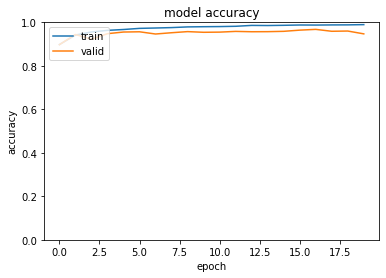

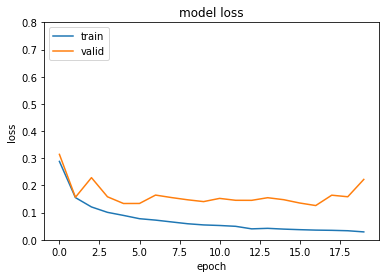

In [43]:
import matplotlib.pyplot as plt

# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.ylim(0, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left') 
plt.savefig('cnn1_acc_20e',dpi=200)
plt.show()
# summarize history for loss 
plt.ylim(0, 0.8)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left') 
# plt.savefig('cnn1_loss_20e',dpi=200)
plt.show()

In [86]:
# score, acc = model.evaluate([X_valid_headline, X_valid_article, valid_extra_feature], Y_valid, BATCH_SIZE == BATCH_SIZE)
# print('valid score:', score)
# print('valid accuracy:', acc)

In [87]:
# plot_model(model, to_file='CNN_classifier1_extraFeatures.png', show_layer_names=True, show_shapes=True)
# Image('CNN_classifier1_extraFeatures.png')

In [44]:
predict_test = model.predict(x = [X_test_headline, X_test_article, test_extra_feature], batch_size=BATCH_SIZE, verbose=0, steps=None)
result = pd.DataFrame(predict_test.argmax(axis=1))
result.rename(columns={ result.columns[0]: "class" }, inplace=True)

print(type(result))


<class 'pandas.core.frame.DataFrame'>


In [45]:
# Compute the prediction and true value
correct =    {0: 0, 1:0, 2: 0, 3: 0}
pred_count = {0: 0, 1:0, 2: 0, 3: 0}
true_count = {0: 0, 1:0, 2: 0, 3: 0}

prediction2 = np.argmax(predict_test, axis=-1)
y_train2 = Y_test

# print(Y_test)
for p, t in zip(prediction2, y_train2):
    if p == t:
        correct[p] += 1
    pred_count[p] += 1
    true_count[t] += 1

In [46]:
pred_count

{0: 410, 1: 127, 2: 1014, 3: 3447}

In [47]:
true_count

{0: 368, 1: 84, 2: 891, 3: 3655}

In [48]:
# Precision, Recall, F1 score
for k in correct:
    c, t, p = correct[k], true_count[k], pred_count[k]
    pre = c / p
    rec = c / t
    f1 = 2 * pre * rec / (pre + rec)
#     print("precision at {}: {}".format(k, pre))
#     print("recall at {}: {}".format(k, rec))
    print("f1 at {}: {}".format(k, f1))

f1 at 0: 0.8560411311053985
f1 at 1: 0.6729857819905214
f1 at 2: 0.9070866141732283
f1 at 3: 0.9693044212897776


In [49]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_cnn1_20e_extrafeature',dpi=200)
    plt.show()

In [50]:
def Stance(result, name):
    if result[name] == 0:
        return 'agree'
    elif result[name] == 1:
        return 'disagree'
    elif result[name] == 2:
        return 'discuss'
    else:
        return 'unrelated'

pred_label = result.apply(lambda r: Stance(r, 'class'), axis=1).values

In [51]:
def StanceInt(stanceLevel):
    if stanceLevel == 0:
        return 'agree'
    elif stanceLevel == 1:
        return 'disagree'
    elif stanceLevel == 2:
        return 'discuss'
    else:
        return 'unrelated'

true_lable = [StanceInt(x) for x in Y_test]

In [52]:
cnf_matrix = confusion_matrix(true_lable, pred_label, labels=['agree', 'disagree', 'discuss', 'unrelated'])
class_names = ['agree', 'disagree', 'discuss', 'unrelated']

Confusion matrix, without normalization
[[ 333   17   14    4]
 [  10   71    3    0]
 [  23    3  864    1]
 [  44   36  133 3442]]


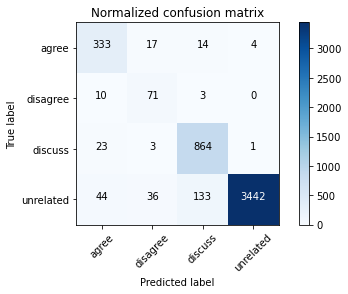

In [53]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

discuss result: the reason why can not identify the 'disagree'
1. imbalance data
2. the strcuture of CNN is too simple
3. ...

In [54]:
from sklearn.metrics import f1_score
f1_score(true_lable, pred_label, average = "macro")

0.8513544871397314

In [55]:
# Defining the accuracy 
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x] == predictions[x]:
            correct += 1
    return (correct/float(len(testSet))) * 1

In [56]:
print(getAccuracy(true_lable, pred_label))

0.9423769507803121


# weighted score

In [57]:
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


# def print_confusion_matrix(cm):
#     lines = []
#     header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
#     line_len = len(header)
#     lines.append("-"*line_len)
#     lines.append(header)
#     lines.append("-"*line_len)

#     hit = 0
#     total = 0
#     for i, row in enumerate(cm):
#         hit += row[i]
#         total += sum(row)
#         lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
#                                                                    *row))
#         lines.append("-"*line_len)
#     print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

#     print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

In [58]:
# print("Scores:")
report_score(true_lable,pred_label)


Score: 2146.0 out of 2256.75	(95.09250027694694%)


95.09250027694694